In [1]:
import SDR
import statsmodels.api as sm
import pandas as pd
import numpy as np
import scipy as sp
import copy
import imp
import DynamicRegression as DR

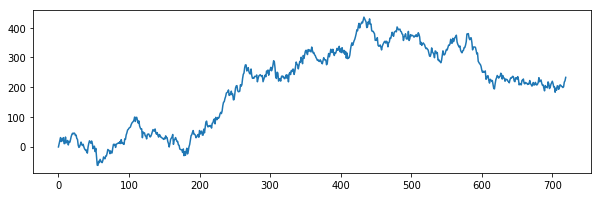

In [3]:
n_points=24*30
np.random.seed(324135)
mod = sm.tsa.UnobservedComponents(np.zeros(n_points),"local linear trend")
coefs = mod.simulate(params=(10,100,.001),nsimulations=n_points,
                    initial_state=(0,0))
pd.Series(coefs).plot(figsize=(10,3))

Generate the exogenous covariates as a sequence of exponentially distributed random variables. The endogenous data is given by multiplying the exogenous covariates by the simulated regression coefficients and adding some noise white.

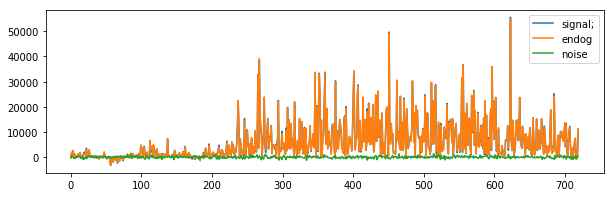

In [4]:
np.random.seed(1235)
exog = np.random.exponential(30,n_points)
noise = np.random.normal(scale=np.var(exog)*.5,size=n_points)
signal = exog*coefs
endog = signal + noise
pd.DataFrame({"signal;":signal,"endog":endog,"noise":noise}).plot(figsize=(10,3))


In [5]:
sdr = DR.dynamic_regression(
    endog,exog,exog_models={"irregular":True,"trend":True})

results = sdr.fit()

/home/alastair-eng/git/DynamicRegression/DynamicRegression.py:222: ComplexWarning: Casting complex values to real discards the imaginary part
  self.ssm.obs_cov[0,0,0]= obs_cov
/home/alastair-eng/git/DynamicRegression/DynamicRegression.py:224: ComplexWarning: Casting complex values to real discards the imaginary part
  self.k_state_cov)] = state_cov_params


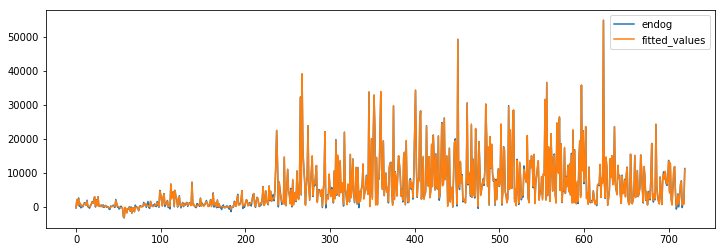

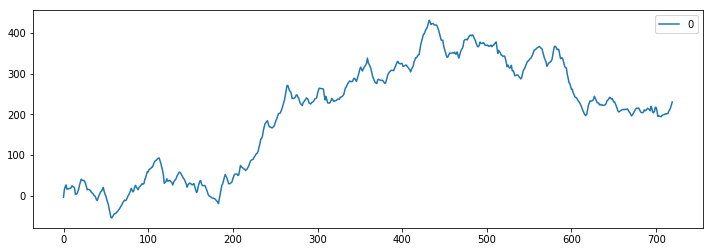

In [6]:
DR.plot_dynamic_regression(results,which ="`smoothed",figsize=(12,4))